# Debugging and performances

In [1]:
# Hidden cell
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
print("xarray: %s, %s" % (xr.__version__, xr.__file__))

import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(0, os.path.abspath('/Users/gmaze/git/github/gmaze/pyxpcm'))

import pyxpcm
print("pyxpcm: %s, %s" % (pyxpcm.__version__, pyxpcm.__file__))

xarray: 0.12.1, /Users/gmaze/anaconda/envs/obidam36/lib/python3.6/site-packages/xarray/__init__.py
pyxpcm: 0.4.0, /Users/gmaze/git/github/gmaze/pyxpcm/pyxpcm/__init__.py


## Load data

In [13]:
# ds = pyxpcm.tutorial.open_dataset('argo').load()
# ds = pyxpcm.tutorial.open_dataset('isas_snapshot').load()
ds = pyxpcm.tutorial.open_dataset('isas_series').load()
print(ds)
print('This dataset holds: %.1f MB' % (ds.nbytes / 1e6))

<xarray.Dataset>
Dimensions:      (depth: 152, latitude: 53, longitude: 61, time: 12)
Coordinates:
  * time         (time) datetime64[ns] 2005-01-15 2005-02-15 ... 2005-12-15
  * latitude     (latitude) float32 30.023445 30.455408 ... 49.41288 49.737103
  * longitude    (longitude) float32 -70.0 -69.5 -69.0 ... -41.0 -40.5 -40.0
  * depth        (depth) float32 -1.0 -3.0 -5.0 ... -1960.0 -1980.0 -2000.0
Data variables:
    PSAL         (time, depth, latitude, longitude) float32 dask.array<shape=(12, 152, 53, 61), chunksize=(12, 152, 53, 61)>
    PSAL_ERR     (time, depth, latitude, longitude) float32 dask.array<shape=(12, 152, 53, 61), chunksize=(12, 152, 53, 61)>
    PSAL_PCTVAR  (time, depth, latitude, longitude) float32 dask.array<shape=(12, 152, 53, 61), chunksize=(12, 152, 53, 61)>
    TEMP         (time, depth, latitude, longitude) float32 dask.array<shape=(12, 152, 53, 61), chunksize=(12, 152, 53, 61)>
    TEMP_ERR     (time, depth, latitude, longitude) float32 dask.array<shape=

## Define/fit/predict a standard pyXpcm

In [14]:
from pyxpcm.pcmodel import pcm

In [23]:
# Define vertical axis and features to use:
z = np.arange(0.,-1000.,-10.)
features_pcm = {'temperature': z}
features_in_ds = {'temperature': 'TEMP'}

features_pcm = {'temperature': z, 'salinity': z}
features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}

features_pcm = {'temperature': z, 'salinity': z, 'sst': None}
features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL', 'sst':'SST'}

In [16]:
# pyXpcm variables added to the dataset can be removed with:
# print('Before:', ds.data_vars)
# ds = ds.pyxpcm.clean()
# print('After cleaning:', ds.data_vars)

## Debugging

Use option ``debug`` to print log messages 

In [24]:
# Clean up dataset of previous results:
ds = ds.pyxpcm.clean()

# Instantiate a new PCM:
m = pcm(K=8, features=features_pcm, debug=True)

# Fit with log:
ds.pyxpcm.fit_predict(m, features=features_in_ds, inplace=True);

sst is single level, not need to reduce
> Start preprocessing for action 'fit_predict'

	> Preprocessing xarray dataset 'TEMP' as PCM feature 'temperature'
	 [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((27636,), (152,))] X RAVELED with success
		Output axis is new, will use interpolation
		Data array before vertical mixing: [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((27636,), (152,))]
		Data array vertically mixed to reached the surface: [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((27636,), (153,))]
		Data array before interpolation: [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((27636,), (153,))]
		Data array after interpolation: [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((27636,), (100,))]
	 [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((27636,), (100,))] X INTERPOLATED with success)
	

ValueError: output array is read-only

## Performance / Optimisation

Use ``timeit`` and ``timeit_verb`` to compute computation time of PCM operations

Times are accessible as a pandas Dataframe in ``timeit`` pyXpcm instance property.

The pyXpcm ``m.plot.timeit()`` plot method allows for a simple visualisation of times.

### Time readings at execution time

In [18]:
# Create a PCM and use several methods to time:
m = pcm(K=8, features=features_pcm, timeit=True)
m.fit(ds, features=features_in_ds);
m.predict(ds, features=features_in_ds);
m.fit_predict(ds, features=features_in_ds);

In [8]:
# Timing are accessible through a dataframe in the timeit property:
m.timeit

Method       Sub-method    Sub-sub-method         Sub-sub-sub-method
fit          1-preprocess  1-mask                 total                   23.549795
                           2-feature_temperature  1-ravel                161.688089
                                                  2-interp                 1.364231
                                                  3-scale_fit            278.012037
                                                  4-scale_transform      130.355835
                                                  5-reduce_fit            17.712116
                                                  6-reduce_transform       4.034996
                                                  total                  593.348026
                           total                                        1213.412046
                           3-homogeniser          total                    1.683950
                           4-xarray               total                    1.109123
       

### Compare details of steps for each method

Sub-method,1-preprocess,2-fit,2-predict,3-score,3-xarray,4-predict,5-score,6-xarray,score
Method,,,,,,,,,
fit,5765.321016,7142.683029,NaN,28.122187,NaN,NaN,NaN,NaN,NaN
fit_predict,3775.321484,8094.488144,NaN,53.404808,NaN,19.109011,27.283907,1071.264982,NaN
predict,4043.168068,NaN,27.491093,NaN,1128.00169,NaN,NaN,NaN,33.606052


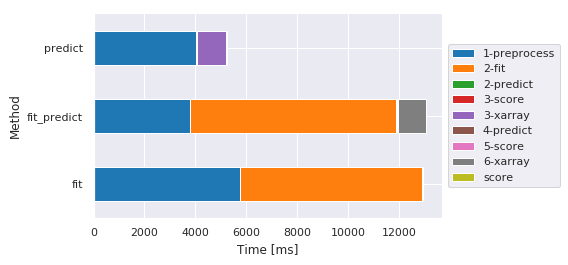

In [21]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-method', style='darkgrid') # Default group/split
df

### Compare preprocessing steps for each method

Sub-sub-method,1-mask,2-feature_temperature,3-homogeniser,4-xarray
Method,,,,
fit,217.428923,2656.340122,5.228758,3.391266
fit_predict,114.725113,1763.938189,5.244255,3.433943
predict,172.873974,1845.067501,0.000715,3.372908


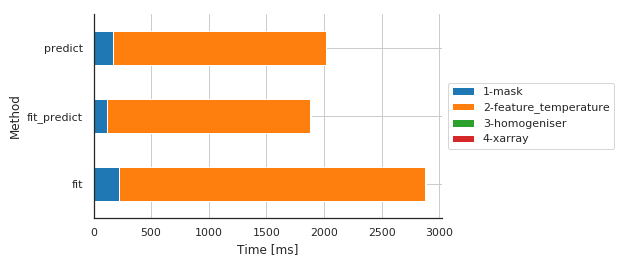

In [22]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-method')
df

### Compare details of preprocessing steps for each method

Sub-sub-sub-method,1-ravel,2-interp,3-scale_fit,4-scale_transform,5-reduce_fit,6-reduce_transform
Method,,,,,,
fit,511.997223,250.325918,300.670147,97.689152,125.962019,41.424751
fit_predict,476.260185,237.729073,0.000954,126.914740,0.002146,40.981054
predict,485.560894,260.028839,0.000954,134.032726,0.000954,42.835951


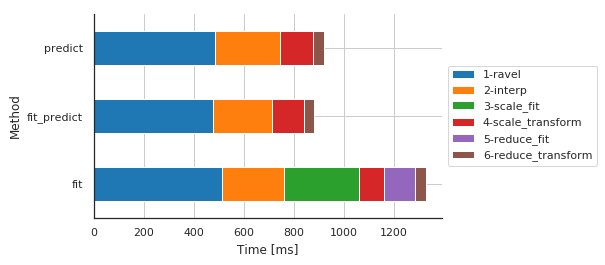

In [20]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-sub-method')
df

### Compare details of preprocessing steps for each feature

Sub-sub-sub-method,1-ravel,2-interp,3-scale_fit,4-scale_transform,5-reduce_fit,6-reduce_transform
Sub-sub-method,,,,,,
2-feature_temperature,1473.818302,748.08383,300.672054,358.636618,125.965118,125.241756


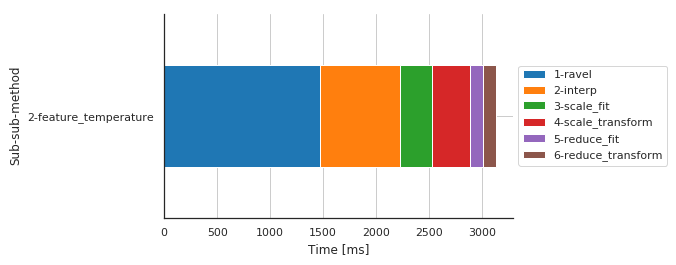

In [19]:
fig, ax, df = m.plot.timeit(split='Sub-sub-sub-method', group='Sub-sub-method')
df